# Калибровка

In [277]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.datasets import fetch_openml
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame

# Целевая переменная
df["target"] = (df["class"] == ">50K").astype(int)
df = df.drop(columns=["class"])


df.loc[df.workclass.isna(),'workclass'] = df.workclass.mode()[0]
df.loc[df.occupation.isna(),'occupation'] = df.occupation.mode()[0]
df.loc[df['native-country'].isna(),'native-country'] = df['native-country'].mode()[0]

/Users/kolontay/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



In [278]:
df.drop(['relationship','marital-status','education-num','education','hours-per-week','occupation'],axis =1,inplace = True)

In [279]:
# найдём все нечисловые колонки
cat_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# приведём их к object (чтобы CatBoost понял, что это категориальные)
for c in cat_cols:
    df[c] = df[c].astype("object")

In [280]:
from sklearn.model_selection import train_test_split

# Отделим целевую переменную
y = df["target"].values
X = df.drop(columns=["target"])

# Сначала train (60%) и temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Потом temp делим поровну на valid (20%) и test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Valid size:", X_valid.shape)
print("Test size:", X_test.shape)

Train size: (29305, 8)
Valid size: (9768, 8)
Test size: (9769, 8)


In [281]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Найдём категориальные признаки (в adult они object)
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Базовая модель без особого тюнинга
model = CatBoostClassifier(
    iterations=200,       # число деревьев
    depth=6,              # глубина
    learning_rate=0.1,    # шаг
    eval_metric="AUC",
    verbose=50,
    random_state=42
)

# Обучение на train + валидация на valid
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

# Предсказания вероятностей на test
proba_test = model.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc = roc_auc_score(y_test, proba_test)
print("ROC AUC на тесте:", roc_auc)

0:	test: 0.7986904	best: 0.7986904 (0)	total: 13.1ms	remaining: 2.61s
50:	test: 0.8403733	best: 0.8403733 (50)	total: 485ms	remaining: 1.42s
100:	test: 0.8459058	best: 0.8459058 (100)	total: 935ms	remaining: 917ms
150:	test: 0.8521588	best: 0.8521588 (150)	total: 1.44s	remaining: 467ms
199:	test: 0.8534818	best: 0.8535320 (192)	total: 1.91s	remaining: 0us

bestTest = 0.8535320268
bestIteration = 192

Shrink model to first 193 iterations.
ROC AUC на тесте: 0.8559741639047299


In [282]:
model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,age,38.805597
1,capital-gain,31.395116
2,capital-loss,14.948777
3,sex,6.167647
4,race,2.855968
5,native-country,2.143132
6,workclass,2.105689
7,fnlwgt,1.578073


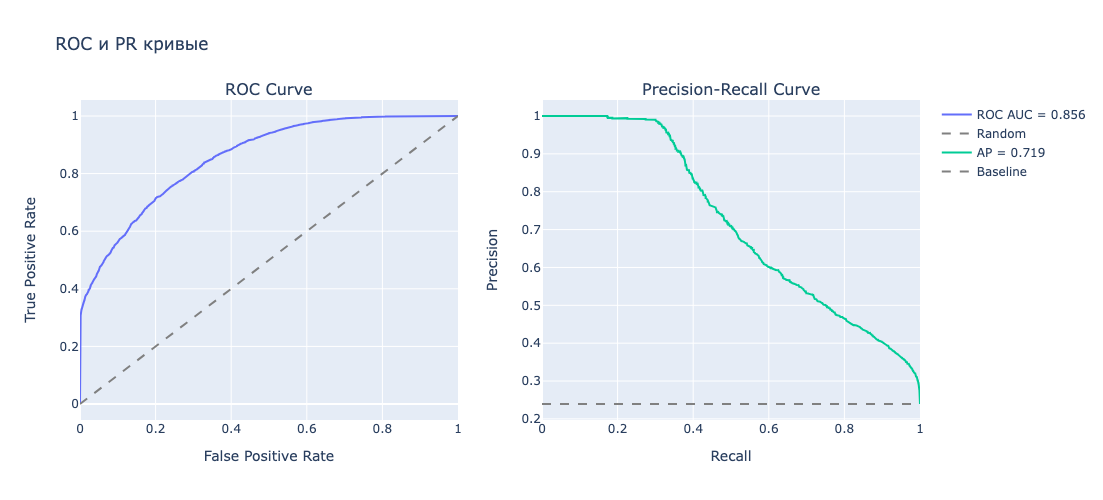

In [283]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# ROC данные
fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)

# PR данные
precision, recall, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

# Создаём subplot: 1 строка, 2 колонки
fig = make_subplots(rows=1, cols=2, subplot_titles=("ROC Curve", "Precision-Recall Curve"))

# ROC кривая
fig.add_trace(
    go.Scatter(
        x=fpr, y=tpr,
        mode="lines",
        name=f"ROC AUC = {roc_auc:.3f}",
        hovertemplate="FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>"
    ),
    row=1, col=1
)

# Диагональ (baseline)
fig.add_trace(
    go.Scatter(
        x=[0,1], y=[0,1],
        mode="lines",
        name="Random",
        line=dict(dash="dash", color="grey")
    ),
    row=1, col=1
)

# PR кривая
fig.add_trace(
    go.Scatter(
        x=recall, y=precision,
        mode="lines",
        name=f"AP = {ap:.3f}",
        hovertemplate="Recall: %{x:.3f}<br>Precision: %{y:.3f}<extra></extra>"
    ),
    row=1, col=2
)

# Базовая линия PR (средняя доля положительного класса)
baseline = y_test.mean()
fig.add_trace(
    go.Scatter(
        x=[0,1], y=[baseline, baseline],
        mode="lines",
        name="Baseline",
        line=dict(dash="dash", color="grey")
    ),
    row=1, col=2
)

# Оформление
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="Recall", row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)

fig.update_layout(title_text="ROC и PR кривые", width=1000, height=500)

fig.show()

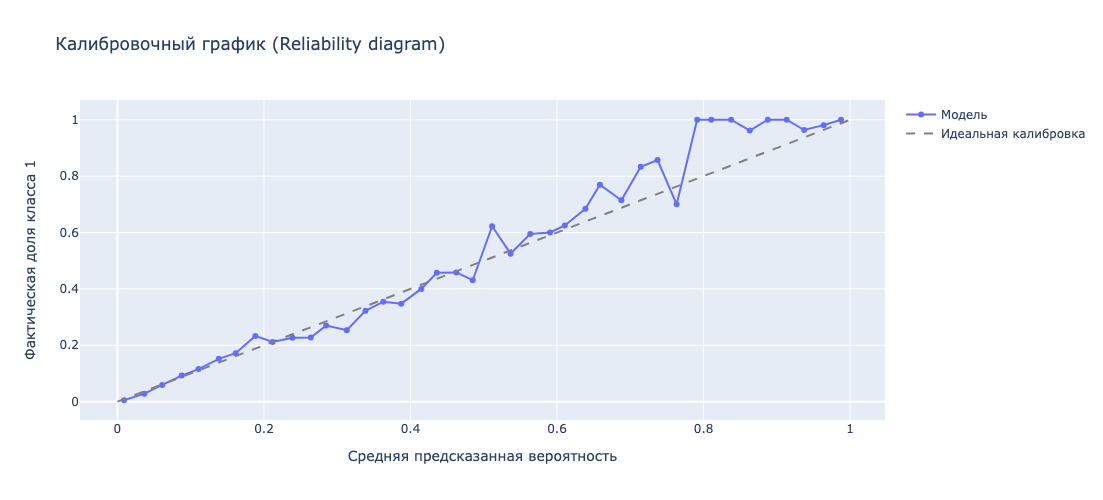

In [284]:
import numpy as np
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go

# calibration_curve разбивает предсказания на бины и считает:
# prob_true – фактическая доля класса 1
# prob_pred – средняя предсказанная вероятность
prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=40, strategy="uniform")

# Строим график
fig = go.Figure()

# Калибровочные точки
fig.add_trace(
    go.Scatter(
        x=prob_pred, y=prob_true,
        mode="markers+lines",
        name="Модель",
        hovertemplate="Predicted: %{x:.3f}<br>Actual: %{y:.3f}<extra></extra>"
    )
)

# Идеальная линия y = x
fig.add_trace(
    go.Scatter(
        x=[0, 1], y=[0, 1],
        mode="lines",
        name="Идеальная калибровка",
        line=dict(dash="dash", color="grey")
    )
)

fig.update_layout(
    title="Калибровочный график (Reliability diagram)",
    xaxis_title="Средняя предсказанная вероятность",
    yaxis_title="Фактическая доля класса 1",
    width=600,
    height=500
)

fig.show()

In [285]:
def calibration_bins(y_true, y_prob, n_bins=10, strategy="uniform"):
    """
    Возвращает статистики по бинам:
    edges, bin_index, bin_counts, bin_pred, bin_true
    strategy: 'uniform' (равные интервалы) или 'quantile' (по квантилям y_prob)
    """
    y_true = np.asarray(y_true).astype(float)
    y_prob = np.asarray(y_prob).astype(float)
    assert y_true.shape == y_prob.shape
    
    if strategy == "uniform":
        edges = np.linspace(0.0, 1.0, n_bins + 1)
        bin_index = np.clip(np.digitize(y_prob, edges, right=True) - 1, 0, n_bins - 1)
    elif strategy == "quantile":
        qs = np.linspace(0.0, 1.0, n_bins + 1) # от 0 до 1 на bin частей
        edges = np.quantile(y_prob, qs)
        # защитимся от совпадающих границ
        edges[0], edges[-1] = 0.0, 1.0
        # вращаем минимальные зазоры
        for k in range(1, len(edges)):
            if edges[k] <= edges[k-1]:
                edges[k] = np.nextafter(edges[k-1], 1.0)
        bin_index = np.clip(np.digitize(y_prob, edges, right=True) - 1, 0, n_bins - 1)
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'")
    
    bin_counts = np.bincount(bin_index, minlength=n_bins).astype(int)
    # средняя предсказанная вероятность в каждом бине
    sum_pred = np.bincount(bin_index, weights=y_prob, minlength=n_bins)
    bin_pred = np.divide(sum_pred, np.maximum(bin_counts, 1), where=bin_counts>0)
    # фактическая доля класса 1 в каждом бине
    sum_true = np.bincount(bin_index, weights=y_true, minlength=n_bins)
    bin_true = np.divide(sum_true, np.maximum(bin_counts, 1), where=bin_counts>0)
    return edges, bin_index, bin_counts, bin_pred, bin_true

def ece_mce(y_true, y_prob, n_bins=10, strategy="uniform"):
    """
    ECE = Σ_k (n_k / n) * |acc_k - conf_k|
    MCE = max_k |acc_k - conf_k|
    """
    edges, bin_index, bin_counts, bin_pred, bin_true = calibration_bins(
        y_true, y_prob, n_bins=n_bins, strategy=strategy
    )
    n = len(y_true)
    gaps = np.abs(bin_true - bin_pred)
    weights = bin_counts / max(n, 1)
    ece = np.sum(weights * gaps)
    mce = np.max(gaps) if len(gaps) > 0 else 0.0
    return {"ECE": float(ece), "MCE": float(mce),
            "bin_edges": edges, "bin_counts": bin_counts,
            "bin_pred": bin_pred, "bin_true": bin_true}

In [286]:
res_before = ece_mce(y_test, proba_test, n_bins=10, strategy="uniform")
print("ECE (before):", res_before["ECE"], "MCE:", res_before["MCE"])

ECE (before): 0.014396045343727671 MCE: 0.1280617220046676


In [287]:
import numpy as np
from scipy.special import expit

def prob_to_logit(p, eps=1e-15):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

In [248]:
# Вероятности (сырьё до калибровки)
proba_train = model.predict_proba(X_train)[:, 1]
proba_valid = model.predict_proba(X_valid)[:, 1]
proba_test  = model.predict_proba(X_test)[:, 1]

In [249]:
logits_valid = prob_to_logit(proba_valid)

In [250]:
logits_train = prob_to_logit(proba_train)

In [188]:
# Фит параметров альфа/бета на валидации
from scipy.optimize import minimize

In [240]:
def fit_platt(y_true, logits, l2=0.0):
    y = y_true.astype(float)
    z = logits.astype(float)
    def nll(params):
        a, b = params
        p = expit(a*z + b) # сигмоида
        p = np.clip(p, 1e-15, 1 - 1e-15) # p не должна быть выше 1e-15 и ниже 1 - 1e-15
        loss = -(y*np.log(p) + (1-y)*np.log(1-p)).mean()
        if l2 > 0:
            loss += l2*(a*a + b*b)
        return loss
    res = minimize(nll, x0=[1.0, 0.0], method="L-BFGS-B")
    return res.x

In [246]:
from scipy.special import expit
import numpy as np
from scipy.optimize import minimize

def fit_platt_with_logs(y, z, l2=0.0, verbose=True):
    y = y.astype(float); z = z.astype(float)

    def loss_and_grad(params):
        a, b = params
        s = a*z + b
        p = expit(s)
        # лосс
        eps = 1e-15
        p_clip = np.clip(p, eps, 1-eps)
        loss = -(y*np.log(p_clip) + (1-y)*np.log(1-p_clip)).mean() + l2*(a*a + b*b)
        # градиент (аналитически)
        diff = p - y
        grad_a = (diff * z).mean() + 2*l2*a
        grad_b = diff.mean() + 2*l2*b
        return loss, np.array([grad_a, grad_b])

    history = []
    def cb(xk):
        L, g = loss_and_grad(xk)
        if verbose:
            print(f"a={xk[0]: .4f}  b={xk[1]: .4f}  loss={L: .6f}  |g|={np.linalg.norm(g): .3e}")
        history.append((xk.copy(), L))

    res = minimize(
        fun=lambda th: loss_and_grad(th)[0],
        x0=np.array([1.0, 0.0]),
        jac=lambda th: loss_and_grad(th)[1],
        method="L-BFGS-B",
        callback=cb
    )
    return res.x, history

In [251]:
y = y_train.astype(float)
z = logits.astype(float)
fit_platt_with_logs(y, logits_train, l2=0.0, verbose=True)

a= 1.0436  b= 0.0003  loss= 0.469611  |g|= 7.184e-03
a= 1.0511  b= 0.0183  loss= 0.469501  |g|= 5.561e-03
a= 1.1164  b= 0.1257  loss= 0.469191  |g|= 1.120e-03
a= 1.1244  b= 0.1320  loss= 0.469188  |g|= 1.267e-04
a= 1.1252  b= 0.1325  loss= 0.469188  |g|= 1.633e-06


(array([1.12515267, 0.13245917]),
 [(array([1.04357207e+00, 2.71906569e-04]), 0.46961132940755573),
  (array([1.05108062, 0.01833173]), 0.46950098287427533),
  (array([1.11639082, 0.12573715]), 0.46919088413211085),
  (array([1.12439582, 0.1320191 ]), 0.46918756072891044),
  (array([1.12515267, 0.13245917]), 0.469187529302075)])

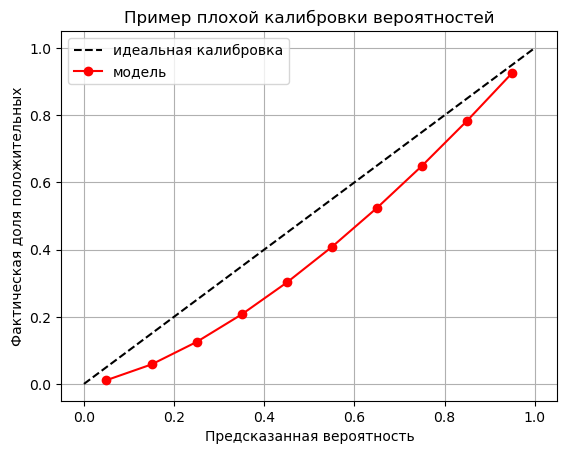

In [288]:
import numpy as np
import matplotlib.pyplot as plt

# искусственные "плохо откалиброванные" данные
pred_probs = np.linspace(0.05, 0.95, 10)       # предсказанные вероятности
true_frac = pred_probs**1.5                    # искусственно заваленные вниз реальные частоты

# диагональ (идеальная калибровка)
plt.plot([0, 1], [0, 1], "k--", label="идеальная калибровка")

# наша "плохая калибровка"
plt.plot(pred_probs, true_frac, "o-", color="red", label="модель")

plt.xlabel("Предсказанная вероятность")
plt.ylabel("Фактическая доля положительных")
plt.title("Пример плохой калибровки вероятностей")
plt.legend()
plt.grid(True)
plt.show()

In [290]:
true_frac

array([0.01118034, 0.05809475, 0.125     , 0.20706279, 0.30186918,
       0.40789092, 0.52404675, 0.64951905, 0.78366128, 0.92594546])